In [1]:
class Particle:
    def __init__(self, particleText, METPhi):
        
        #Get our list of quantities for the particle
        particleInfo = particleText.split(",")
        
        #Define our particle quantities
        self.obj = particleInfo[0]
        self.E = float(particleInfo[1])
        self.pt = float(particleInfo[2])
        self.eta = float(particleInfo[3])
        self.phi = float(particleInfo[4])
        self.deltaPhi = abs(self.phi-METPhi)
        
    def __str__(self):
        return "(obj: " + self.obj + ", E: " + str(self.E) + ", pt: " + str(self.pt) + ", eta: " + str(self.eta) + ", phi: " +str(self.phi) + ")"
    
    def getQuantity(self, quantityType):
        
        if quantityType == "E":
            return self.E
        
        elif quantityType == "pt":
            return self.pt
        
        elif quantityType == "eta":
            return self.eta
        
        elif quantityType == "phi":
            return self.phi
        
        elif quantityType == "deltaPhi":
            return self.deltaPhi
        
        else:
            print("Error: Invalid quantity type")
            return 0.0
        
    __repr__=__str__

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dense, Input
from keras.activations import relu
from sklearn.metrics import roc_curve, auc

In [3]:
def makeMatrixValues(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the values to put in our momentum matrix
    ptSum = sum(ptList)
    pxSquaredSum = sum(pxSquaredList)/ptSum
    pySquaredSum = sum(pySquaredList)/ptSum
    pxpySum = sum(pxpyList)/ptSum
    
    return pxSquaredSum, pySquaredSum, pxpySum

In [4]:
def createMatrix(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the values to put in our momentum matrix
    pxSquaredSum, pySquaredSum, pxpySum = makeMatrixValues(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    #Create the momentum matrix
    pMatrix = [[pxSquaredSum, pxpySum], [pxpySum, pySquaredSum]]
    
    return pMatrix

In [5]:
def getEigenValues(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the momentum matrix
    pMatrix = createMatrix(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    #Get the eigenvalues of our momentum matrix. We will use these eigenvalues to calculate transverse sphericity
    eigenValues, eigenVectors = np.linalg.eig(pMatrix)
    
    return eigenValues

In [6]:
def computeSTFromEigenValues(eigenValues):
    
    #Define the eigenvalues needed to calculate transverse sphericity
    eigenValue1 = max(eigenValues)
    eigenValue2 = min(eigenValues)
    
    ST = 2.0*eigenValue2/(eigenValue1+eigenValue2)
    
    return ST

In [7]:
def getPValues(particle):
    
    #Get the particle quantities needed to get these values
    pt = particle.pt
    phi = particle.phi
    
    #Get the x and y components of momentum
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    
    #These are values needed to create the momentum matrix to calcule transverse sphericity
    pxSquared = px**2/pt
    pySquared = py**2/pt
    pxpy = px*py/pt
    
    return pt, pxSquared, pySquared, pxpy

In [8]:
def checkJets(obj):
    return obj in ["j", "b"]

def checkLeptons(obj):
    return obj in ["e-", "e+", "m-", "m+"]

def checkPhotons(obj):
    return obj=="g"

In [9]:
def calculateST(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Make the matrix and get the eigenvalues needed to calculate ST
    eigenValues = getEigenValues(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    ST = computeSTFromEigenValues(eigenValues)
    
    return ST

In [10]:
def makeFeatures(MET, METPhi, eventInfo):
    
    #total number of datapoints in the line
    length = len(eventInfo)
    
    # define quantitity lists needed for calculating transverse sphericity
    particleList = []
    
    pxSquaredList = []
    pySquaredList = []
    pxpyList = []
    ptList = []
    
    deltaPhiList = []
    
    #Define the absolute sum of transverse momentum to calculate Meff
    absolutePtSum = 0.0
    leadingPt = 0.0
    
    #Define the count for the various particle types
    jets = 0
    leptons = 0
    photons = 0
    
    #Increment over all of the particles in the line
    for i in range(5, length):
        
        #Get the text for the particle
        particleText = eventInfo[i]
        
        #Make sure that it is actually information for the particle
        if particleText != "" and particleText != "\n":
            
            particle = Particle(particleText, METPhi)
            
            #get the type of particle
            obj = particle.obj
            
            #count the particles of each type
            if checkJets(obj):
                jets += 1
                
            elif checkLeptons(obj):
                leptons += 1
                
            elif checkPhotons(obj):
                photons += 1
            
            #Get the momentum-derived values needed to calulate features
            pt, pxSquared, pySquared, pxpy = getPValues(particle)
            
            if pt > leadingPt:
                leadingPt = pt
            
            pxSquaredList.append(pxSquared)
            pySquaredList.append(pySquared)
            pxpyList.append(pxpy)
            ptList.append(pt)
            
            absolutePtSum += abs(pt)
            
            particleList.append(particle)
            deltaPhiList.append(particle.deltaPhi)
    
    ST = calculateST(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    Meff = MET + absolutePtSum
    
    return particleList, jets, leptons, photons, Meff, ST, leadingPt, ptList, deltaPhiList

In [11]:
def makeEvent(line, signal):
    
    eventInfo = line.split(";")
    
    eventID = eventInfo[0]
    processID = eventInfo[1]
    eventWeight = float(eventInfo[2])
    MET = float(eventInfo[3])
    METPhi = float(eventInfo[4])
    
    signal = float(signal)
    
    particleList, jets, leptons, photons, Meff, ST, leadingPt, ptList, deltaPhiList = makeFeatures(MET, METPhi, eventInfo)
    
    crossSection = 1.0
    
    event = {
        "eventID" : eventID,
        "processID" : processID,
        "eventWeight" : eventWeight,
        "MET" : MET,
        "METPhi" : METPhi,
        "particleList" : particleList,
        "jets" : jets,
        "leptons" : leptons,
        "photons" : photons,
        "crossSection" : crossSection,
        "Meff" : Meff,
        "ST" : ST,
        "leadingPt" : leadingPt,
        "ptList" : ptList,
        "deltaPhiList" : deltaPhiList,
        "signal" : signal
    }
    
    return event

In [12]:
def calculateSignalCrossSection(event, length):
    
    eventWeight = event["eventWeight"]
    
    crossSection = eventWeight*length
    
    return crossSection

In [13]:
def calculateBackgroundCrossSection(length, luminosity):
    
    crossSection = length/luminosity
    
    return crossSection

In [14]:
def calculateCrossSection(event, length, luminosity, signal):
    if signal:
        return calculateSignalCrossSection(event, length)
    else:
        return calculateBackgroundCrossSection(length, luminosity)

In [15]:
def makeDataList(filePath, signal, luminosity = 1.0):
    
    file = open(filePath, "r")
    
    dataList = []
    
    for line in file:
        
        event = makeEvent(line, signal)
        
        dataList.append(event)

    file.close()
    
    length = float(len(dataList))
    
    for event in dataList:
        
        event["crossSection"] = calculateCrossSection(event, length, luminosity, signal)
    
    
    return dataList

In [16]:
backgroundDataList = makeDataList("Data/training_files/training_files/chan1/background_chan1_7.79.csv", False, luminosity = 7.79)
signalDataList = makeDataList("Data/training_files/training_files/chan1/glgl1400_neutralino1100_chan1.csv", True)

In [17]:
N_Train=2000

trainBackgroundDataList = backgroundDataList[:N_Train]
testBackgroundDataList = backgroundDataList[N_Train:]

trainSignalDataList = signalDataList[:N_Train]
testSignalDataList = signalDataList[N_Train:]

trainDataList = trainBackgroundDataList + trainSignalDataList
testDataList = testBackgroundDataList + testSignalDataList

random.shuffle(trainDataList)
random.shuffle(testDataList)

In [18]:
Train_Sample = pd.DataFrame(data = trainDataList)
Test_Sample = pd.DataFrame(data = testDataList)

VarNames = ["MET", "METPhi", "jets", "leptons", "photons", "Meff", "ST", "leadingPt"]

X_Train = Train_Sample[VarNames]
y_Train = Train_Sample["signal"]

X_Test = Test_Sample[VarNames]
y_Test = Test_Sample["signal"]

Test_sig = Test_Sample[Test_Sample.signal == 1]
Test_bkg = Test_Sample[Test_Sample.signal == 0]

In [19]:
model = Sequential()
model.add(Dense(200, input_dim=X_Train.shape[1], activation='tanh'))
model.add(Dense(200, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1800      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 20)                4020      
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])

In [22]:
history=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=20, batch_size=2048)

Epoch 1/20
2/2 [==============================] - 2s 742ms/step - loss: 0.2518 - accuracy: 0.5512 - val_loss: 0.2677 - val_accuracy: 0.2850
Epoch 2/20
2/2 [==============================] - 1s 492ms/step - loss: 0.2395 - accuracy: 0.6275 - val_loss: 0.2395 - val_accuracy: 0.5643
Epoch 3/20
2/2 [==============================] - 1s 500ms/step - loss: 0.2307 - accuracy: 0.6933 - val_loss: 0.2245 - val_accuracy: 0.6114
Epoch 4/20
2/2 [==============================] - 0s 488ms/step - loss: 0.2175 - accuracy: 0.6990 - val_loss: 0.1950 - val_accuracy: 0.6449
Epoch 5/20
2/2 [==============================] - 1s 495ms/step - loss: 0.2078 - accuracy: 0.7048 - val_loss: 0.1848 - val_accuracy: 0.7046
Epoch 6/20
2/2 [==============================] - 1s 559ms/step - loss: 0.2010 - accuracy: 0.7085 - val_loss: 0.2061 - val_accuracy: 0.6501
Epoch 7/20
2/2 [==============================] - 1s 552ms/step - loss: 0.1957 - accuracy: 0.7135 - val_loss: 0.1915 - val_accuracy: 0.6848
Epoch 8/20
2/2 [====

In [23]:
print (history.history)

{'loss': [0.2517835795879364, 0.23950256407260895, 0.23067864775657654, 0.2174878567457199, 0.20784185826778412, 0.20097224414348602, 0.1957434117794037, 0.1918257772922516, 0.1899646371603012, 0.18909791111946106, 0.18735553324222565, 0.18754379451274872, 0.1884315013885498, 0.1888170838356018, 0.18864022195339203, 0.18651586771011353, 0.1843162477016449, 0.1832108050584793, 0.18198031187057495, 0.18355236947536469], 'accuracy': [0.5512499809265137, 0.6274999976158142, 0.6932500004768372, 0.6990000009536743, 0.7047500014305115, 0.7085000276565552, 0.7135000228881836, 0.7202500104904175, 0.7247499823570251, 0.7267500162124634, 0.7170000076293945, 0.7095000147819519, 0.7127500176429749, 0.7137500047683716, 0.7124999761581421, 0.7045000195503235, 0.7167500257492065, 0.718999981880188, 0.7232499718666077, 0.7262499928474426], 'val_loss': [0.2676716446876526, 0.2395222783088684, 0.22451651096343994, 0.19497615098953247, 0.18483753502368927, 0.2061423361301422, 0.19148147106170654, 0.182917

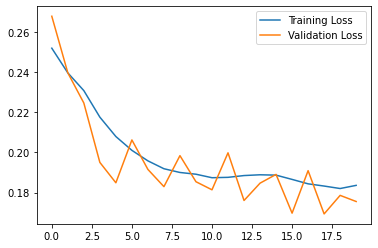

In [24]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

In [25]:
scores = model.evaluate(X_Test, y_Test)
print(scores)

6697/6697 [==============================] - 12s 2ms/step - loss: 0.1755 - accuracy: 0.8014
[0.175523042678833, 0.8014009594917297]


In [26]:
model.predict(X_Test)

6697/6697 [==============================] - 10s 1ms/step


array([[0.2608779 ],
       [0.17012778],
       [0.3453544 ],
       ...,
       [0.34534943],
       [0.17012776],
       [0.7691861 ]], dtype=float32)

6697/6697 [==============================] - 9s 1ms/step


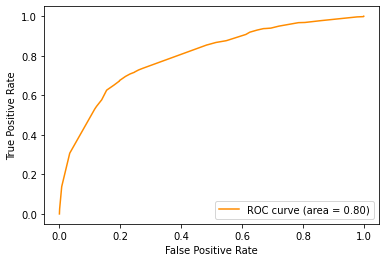

In [27]:
fpr, tpr, _ = roc_curve(y_Test, model.predict(X_Test))
                        
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()